In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit, execute, assemble, schedule, transpile
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [5]:
# Get backend
backend = provider.get_backend('ibmq_belem')
config = backend.configuration()

In [7]:
config.supported_instructions

['sx',
 'delay',
 'measure',
 'shiftf',
 'x',
 'u2',
 'cx',
 'reset',
 'setf',
 'play',
 'u3',
 'acquire',
 'u1',
 'rz',
 'id']

# Single qubit reset experiment

Following the [doc tutorial](https://quantum-computing.ibm.com/docs/manage/systems/reset/backend_reset), the first experiment is to do a superposition using a H gate and measure, and use a reset to see if the qubit is in the 0 state after the reset. The experiment is:

- Without reset:
` H -> X -> measure`

- With reset:
` H -> reset -> X -> measure`

In [17]:
h_x_circ = QuantumCircuit(1, 1)
h_x_circ.h(0)
h_x_circ.x(0)
h_x_circ.measure(0, 0)

def h_reset_x_circ(n_resets):
    """Do h, then n_resets reset instructions, then x on a single qubit."""
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.reset([0]*n_resets)
    qc.x(0)
    qc.measure(0,0)
    return qc

In [18]:
circs0 = [h_x_circ, h_reset_x_circ(1), h_reset_x_circ(3), h_reset_x_circ(5)]
job1q_0 = execute(circs0, backend, initial_layout=[0])
job_monitor(job1q_0)

Job Status: job has successfully run                          


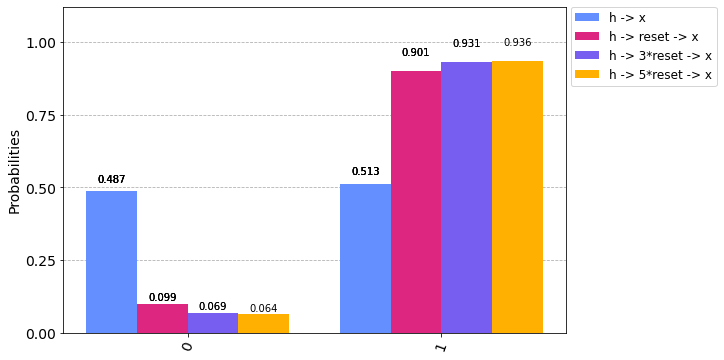

In [19]:
counts1 = job1q_0.result().get_counts()

legend_1q = ['h -> x', 'h -> reset -> x', 'h -> 3*reset -> x', 'h -> 5*reset -> x' ]
plot_histogram(counts1, legend=legend_1q, figsize=(9, 6))

Lets compare the circuit initialized in the state: $| \psi \rangle = \frac{1}{\sqrt{3}} | 0 \rangle + \sqrt{\frac{2}{3}} | 1 \rangle$ and do the same experiment

In [20]:
initialize_x_circ = QuantumCircuit(1, 1)
initialize_x_circ.initialize([1/np.sqrt(3), np.sqrt(2/3)])
initialize_x_circ.x(0)
initialize_x_circ.measure(0, 0)

def initialize_reset_x_circ(n_resets):
    """Initialize, then n_resets reset instructions, then x on a single qubit."""
    qc = QuantumCircuit(1, 1)
    qc.initialize([1/np.sqrt(3), np.sqrt(2/3)])
    qc.reset([0]*n_resets)
    qc.x(0)
    qc.measure(0,0)
    return qc

In [21]:
circs1 = [initialize_x_circ, initialize_reset_x_circ(1), initialize_reset_x_circ(3), initialize_reset_x_circ(5)]
job1q_1 = execute(circs1, backend, initial_layout=[0])
job_monitor(job1q_1)

Job Status: job has successfully run                          


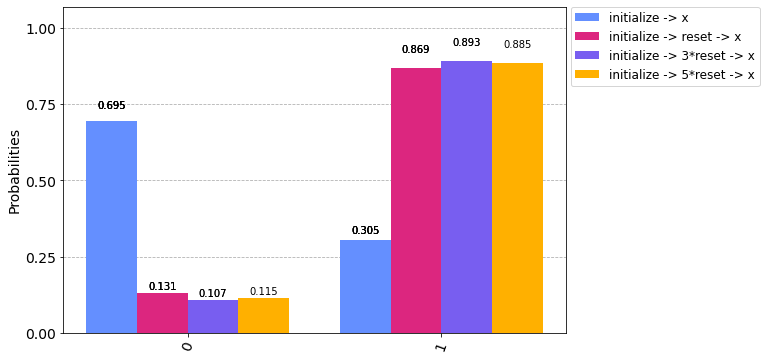

In [22]:
counts2 = job1q_1.result().get_counts()

legend_1q1 = ['initialize -> x', 'initialize -> reset -> x', 'initialize -> 3*reset -> x', 'initialize -> 5*reset -> x' ]
plot_histogram(counts2, legend=legend_1q1, figsize=(9, 6))

# Multi-qubit reset

Let's create an equal superposition and then apply the reset.

In [24]:
def multiq_custom_circ(n_resets):
    """Multi-qubit circuit on qubits 0, 1, 2 with ``n_resets`` reset instructions used."""
    qc = QuantumCircuit(3, 3)
    qc.h(0)
    qc.h(1)
    qc.h(2)
    qc.reset([0]*n_resets)
    qc.cx(0, 2)
    qc.reset([1]*n_resets)
    qc.x(1)
    qc.measure(range(2), range(2))
    return qc

In [25]:
multiq_circs = [multiq_custom_circ(0), multiq_custom_circ(1), multiq_custom_circ(3)]

In [26]:
# verify expected output
from qiskit import Aer
job_multiq_sim = execute(multiq_circs,
                         backend=Aer.get_backend('qasm_simulator'))
counts_multiq_sim = job_multiq_sim.result().get_counts()
print("No reset sim counts, custom circ: ", counts_multiq_sim[0])
print("1 Reset sim counts, custom circ: ", counts_multiq_sim[1])

No reset sim counts, custom circ:  {'001': 267, '000': 236, '010': 262, '011': 259}
1 Reset sim counts, custom circ:  {'010': 1024}


In [27]:
job_multiq = execute(multiq_circs, backend)
job_monitor(job_multiq)

Job Status: job has successfully run                          


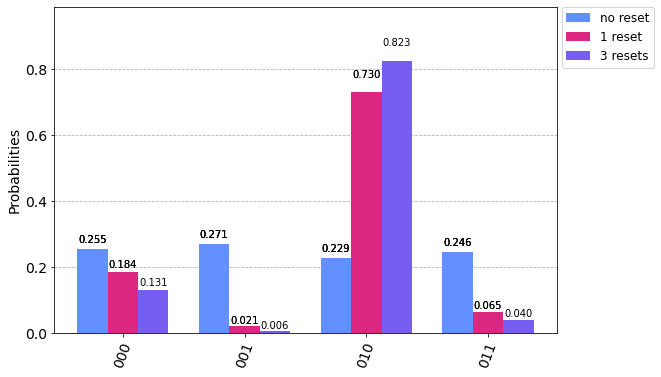

In [28]:
counts_multiq = job_multiq.result().get_counts()
legend_multiq = ['no reset', '1 reset', '3 resets']
plot_histogram(counts_multiq, legend=legend_multiq, figsize=(9, 6))

# References

- [doc tutorial](https://quantum-computing.ibm.com/docs/manage/systems/reset/backend_reset)